In [1]:
%matplotlib notebook


import pickle as pkl
from graph_tool import Graph, load_graph
from glob import glob
from utils import earliest_obs_node
from gt_utils import edges_to_directed_tree, get_roots
from feasibility import is_arborescence
from tqdm import tqdm


In [2]:
g = load_graph('data/grid-64/graph.gt')
p = 'outputs/paper_experiment/grid-64/si/no-order/qs/0.25/90.pkl'
infection_times, source, obs_nodes, true_edges, pred_edges = pkl.load(open(p, 'rb'))
root = earliest_obs_node(obs_nodes, infection_times)
print(root)
t = edges_to_directed_tree(g, root, pred_edges)

assert is_arborescence(t)    

24


In [3]:
from graph_tool import GraphView
from graph_tool.topology import min_spanning_tree
from steiner_tree import get_steiner_tree, build_closure
from utils import extract_edges
from feasibility import is_arborescence
from gt_utils import is_tree

gc, eweight, r2pred = build_closure(g, obs_nodes)
tree_map = min_spanning_tree(gc, eweight, root=None)
gc_tree = GraphView(gc, directed=False, efilt=tree_map)

t = get_steiner_tree(g, obs_nodes)
extract_edges(t)
is_tree(t)

n. edges != n. nodes - 1


False

In [4]:
extract_edges(gc_tree)

[(10, 18),
 (18, 34),
 (27, 18),
 (27, 24),
 (34, 41),
 (41, 58),
 (44, 34),
 (53, 44)]

<IPython.core.display.Javascript object>


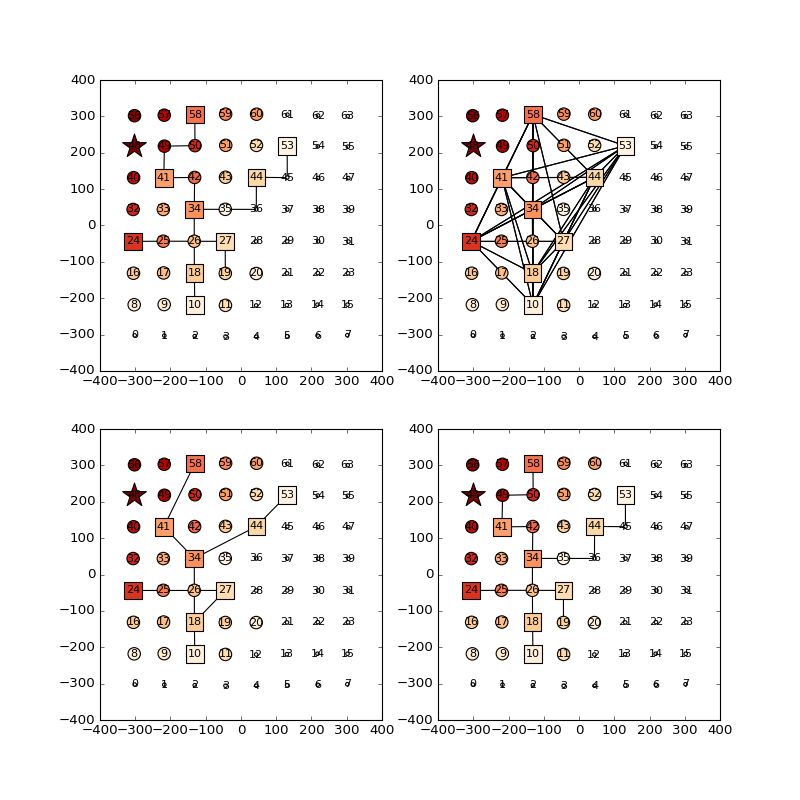

In [14]:
from matplotlib import pyplot as plt

from plot_utils import plot_snapshot
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

gnx = nx.read_graphml('data/grid/2-6/graph.graphml')
gnx = nx.relabel_nodes(gnx, {i: int(i) for i in gnx.nodes_iter()})
pos = graphviz_layout(gnx, root=0)


fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[0, 0],
              edges=extract_edges(t))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[0, 1],
              edges=extract_edges(gc))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[1, 0],
              edges=extract_edges(gc_tree))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[1, 1],
              edges=vis.edges)

In [17]:
t.edge(18, 10)

<Edge object with source '18' and target '10' at 0x7f25982e2dc0>

In [13]:
from graph_tool.search import bfs_search, BFSVisitor
from gt_utils import EdgeCollectorVisitor

def remove_redundant_edges(g, root):
    """for undirected grap, remove redundant edges unvisited by BFS"""
    vis = EdgeCollectorVisitor()
    bfs_search(g, source=root, visitor=vis)
    
    efilt = g.new_edge_property('bool')
    efilt.a = False
    for u, v in vis.edges:
        efilt[g.edge(u, v)] = True
    g.set_edge_filter(efilt)
    return g
t = remove_redundant_edges(t, root)